## Colocando os Conhecimentos em Prática

Na aula de hoje, nós aplicaremos tudo o que foi visto ao longo dessa semana em uma tarefa real (e difícil): a classificação da litologia de um poço. Aqui, deixaremos todo o código para ser feito por vocês, desde o processamento dos dados, até a avaliação do modelo implementado.

Abaixo, estamos apenas baixando a base de dados que utilizaremos: a Force.

A base de dados FORCE (Forum for Reservoir Characterization and Evaluation) é um repositório aberto e colaborativo que contém dados de poços sísmicos, frequentemente utilizados para pesquisas em geociências, aprendizado de máquina e exploração de recursos naturais. A base inclui informações como logs de poços, interpretções sísmicas, mapas estruturais, além de dados associados a formações geológicas. É amplamente empregada em tarefas como segmentação, detecção de falhas e análise de reservatórios.

Acesse a base FORCE através do link: https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition

In [1]:
!wget -nc https://raw.githubusercontent.com/bolgebrygg/Force-2020-Machine-Learning-competition/refs/heads/master/lithology_competition/data/hidden_test.csv
!wget -nc https://raw.githubusercontent.com/bolgebrygg/Force-2020-Machine-Learning-competition/refs/heads/master/lithology_competition/data/leaderboard_test_features.csv
!wget -nc https://raw.githubusercontent.com/bolgebrygg/Force-2020-Machine-Learning-competition/refs/heads/master/lithology_competition/data/leaderboard_test_target.csv
!wget -nc https://raw.githubusercontent.com/bolgebrygg/Force-2020-Machine-Learning-competition/refs/heads/master/lithology_competition/data/train.zip

--2025-01-02 16:22:37--  https://raw.githubusercontent.com/bolgebrygg/Force-2020-Machine-Learning-competition/refs/heads/master/lithology_competition/data/hidden_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30292497 (29M) [text/plain]
Saving to: ‘hidden_test.csv’

hidden_test.csv     100%[===================>]  28.89M   148MB/s    in 0.2s    

2025-01-02 16:22:38 (148 MB/s) - ‘hidden_test.csv’ saved [30292497/30292497]

--2025-01-02 16:22:38--  https://raw.githubusercontent.com/bolgebrygg/Force-2020-Machine-Learning-competition/refs/heads/master/lithology_competition/data/leaderboard_test_features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubu

In [2]:
!unzip -o train.zip

Archive:  train.zip
  inflating: train.csv               


Agora é com você! Construa uma Support Vector Machine, usando pytorch, para mapear cada ponto do poço para a litologia correta.

> Dica: Considere fazer suas predições em uma janela deslizante.

Abaixo está um passo a passo do que deve ser feito.

1. Leia os dados baixados e extraídos
> Dica: use a biblioteca pandas. Exemplo: pd.read_csv("train.csv", sep=';')
2. Divida os poços em janelas da profundidade que quiser.
3. Construa sua base de treino e teste, bem como o dataloder para elas.
4. Construa seu SVM usando pytorch.
5. Treine o modelo.
6. Extraia as previsões em seu dado de teste para cada janela, em junte-as para formar a segmentação completa do poço.
7. Meça a qualidade de seu algoritmo com métricas a sua escolha.


Não se preocupe se os resultados não forem muito bons. Dentro de algumas semanas você verá técnicas novas e mais modernas que serão muito melhores para esse problema!

In [180]:
!pip install torchmetrics

In [101]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torchmetrics.functional import accuracy
from collections import Counter

In [39]:
# Lendo os dados
df_train = pd.read_csv("train.csv", sep=';')
df_test = pd.read_csv("leaderboard_test_features.csv", sep=';')
df_test_target = pd.read_csv("leaderboard_test_target.csv", sep=';')
df_test = pd.merge(df_test, df_test_target, on=["WELL", "DEPTH_MD"], how="inner")

In [40]:
# Nomes das litologias
lithology_keys = {
    30000: 'Sandstone',
    65030: 'Sandstone/Shale',
    65000: 'Shale',
    80000: 'Marl',
    74000: 'Dolomite',
    70000: 'Limestone',
    70032: 'Chalk',
    88000: 'Halite',
    86000: 'Anhydrite',
    99000: 'Tuff',
    90000: 'Coal',
    93000: 'Basement'
}

target_col = "FORCE_2020_LITHOFACIES_LITHOLOGY"
feature_cols = ["GR", "RHOB", "NPHI", "PEF", "DTC", "DTS", "RDEP", "RSHA", "RMED"]

# Removendo valores faltantes
df_train = df_train.dropna(subset=feature_cols+[target_col]).reset_index(drop=True)
df_test = df_test.dropna(subset=feature_cols+[target_col]).reset_index(drop=True)

# Codificando as labels para que as possamos passar para o modelo
le = LabelEncoder()
all_possible_classes = list(lithology_keys.keys())
le.fit(all_possible_classes)
df_train[target_col] = le.transform(df_train[target_col])
df_test[target_col] = le.transform(df_test[target_col])

# Normalizando as featues
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

In [41]:
# Criando janelas nos dados
def create_windows(data, features, target, window_size=10):
    X = []
    Y = []
    for i in range(len(data) - window_size):
        x_window = data[features].iloc[i:i+window_size].values
        y_target = data[target].iloc[i+window_size]
        X.append(x_window)
        Y.append(y_target)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

window_size = 10
X_train, Y_train = create_windows(df_train, feature_cols, target_col, window_size=window_size)
X_test, Y_test = create_windows(df_test, feature_cols, target_col, window_size=window_size)

In [42]:
# Criando o dataset que utilizaremos
class WellDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# definindo os datasets
train_dataset = WellDataset(X_train, Y_train)
test_dataset = WellDataset(X_test, Y_test)

# definindo os dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [43]:
# Hinge loss para classificão multi-classe
class MultiClassHingeLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(MultiClassHingeLoss, self).__init__()
        self.margin = margin

    def forward(self, inputs, targets):
        batch_size, num_classes = inputs.size()
        correct_scores = inputs[torch.arange(batch_size), targets].unsqueeze(1)
        margins = self.margin - correct_scores + inputs
        margins[torch.arange(batch_size), targets] = 0
        loss = torch.mean(torch.sum(torch.clamp(margins, min=0), dim=1))
        return loss

In [44]:
# Definindo nosso modelo
class SVMModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SVMModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(batch_size, -1)
        out = self.linear(x)
        return out

In [45]:
# Treino de uma única epoch
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X_batch, Y_batch in loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(outputs, dim=1)
        total_correct += (preds == Y_batch).sum().item()
        total_samples += X_batch.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc

In [46]:
# Avaliação do modelo
def eval_model(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)

            total_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == Y_batch).sum().item()
            total_samples += X_batch.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc

In [47]:
# Inicializando o modelo
num_features = len(feature_cols)
num_classes = len(le.classes_)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SVMModel(input_dim=window_size*num_features, num_classes=num_classes).to(device)

criterion = MultiClassHingeLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [48]:
# Treinando o modelo
epochs = 10

for epoch in range(1, epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch}/{epochs}: Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = eval_model(model, test_loader, criterion)
print(f"Test - Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")


Epoch 1/10: Train - Loss: 3.7015, Acc: 0.5950
Epoch 2/10: Train - Loss: 1.7109, Acc: 0.6781
Epoch 3/10: Train - Loss: 1.3950, Acc: 0.6995
Epoch 4/10: Train - Loss: 1.2749, Acc: 0.7140
Epoch 5/10: Train - Loss: 1.2130, Acc: 0.7183
Epoch 6/10: Train - Loss: 1.1725, Acc: 0.7214
Epoch 7/10: Train - Loss: 1.1429, Acc: 0.7246
Epoch 8/10: Train - Loss: 1.1228, Acc: 0.7265
Epoch 9/10: Train - Loss: 1.1077, Acc: 0.7263
Epoch 10/10: Train - Loss: 1.0940, Acc: 0.7277
Test - Loss: 2.3139, Acc: 0.6592


(36938,)
(2961,)


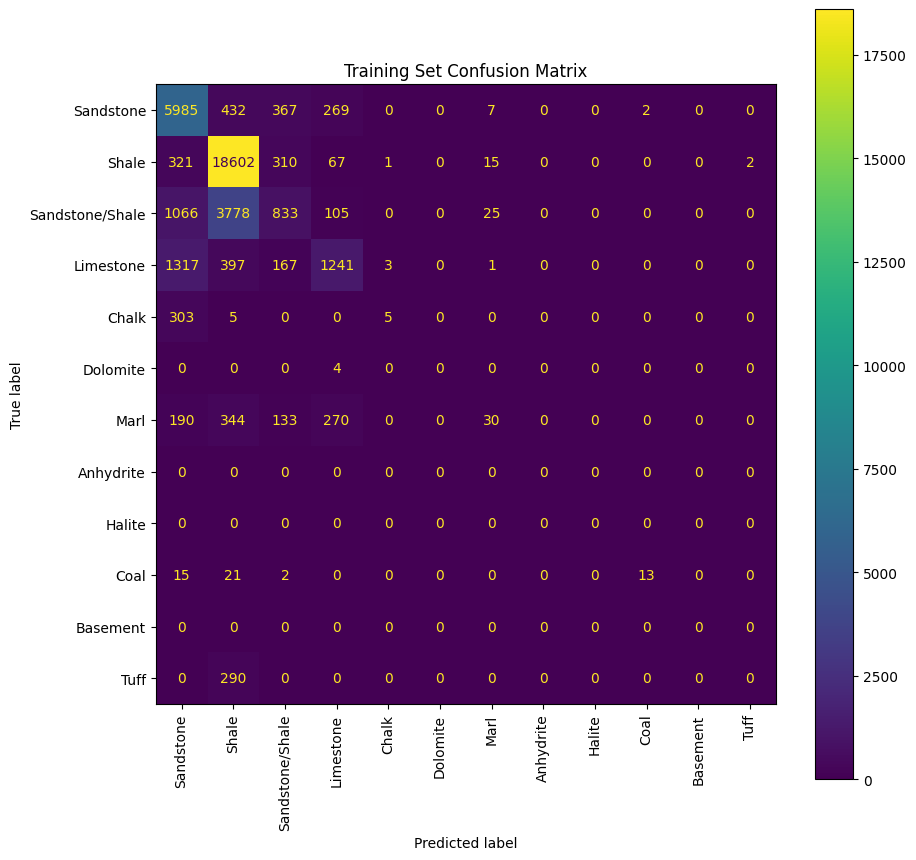

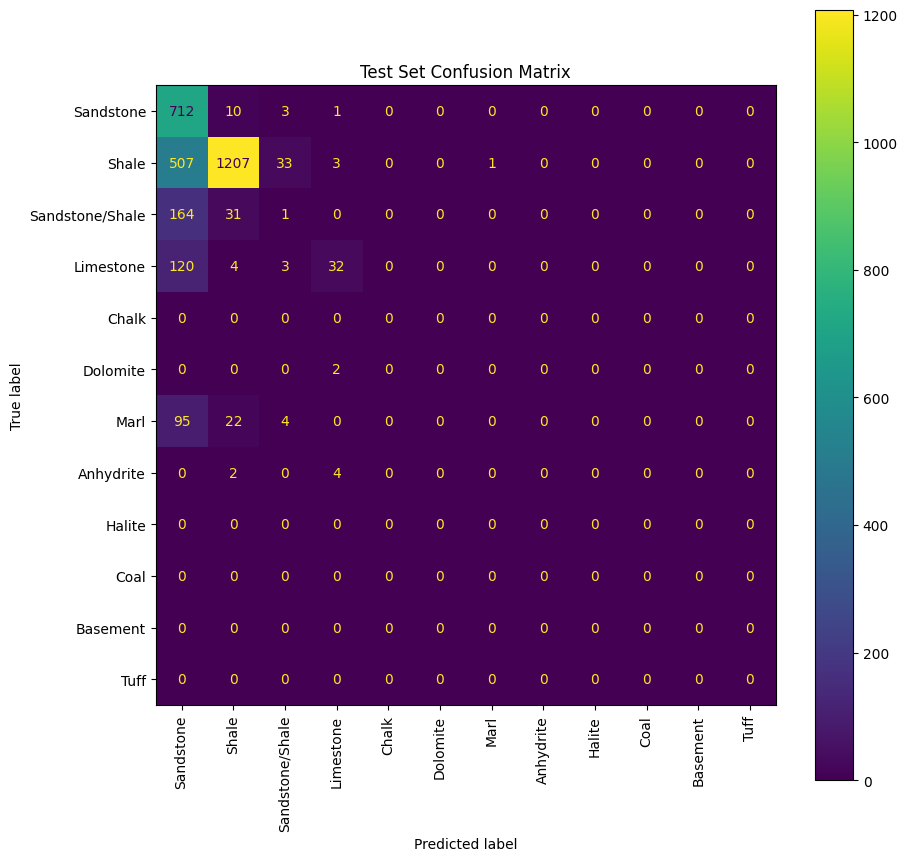

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extrai todas as predições para cada janela
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(Y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    print(all_preds.shape)
    return all_targets, all_preds

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last = False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last = False)

train_targets, train_preds = get_predictions(model, train_loader)
test_targets, test_preds = get_predictions(model, test_loader)

# Recupera o nome das labels
label_names = [lithology_keys[k] for k in le.inverse_transform(range(num_classes))]

# Calculando a matriz de confusão para cada janela
train_cm = confusion_matrix(train_targets, train_preds, labels=range(num_classes))
test_cm = confusion_matrix(test_targets, test_preds, labels=range(num_classes))

# Exibindo a matriz de confusão do treino
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=label_names)
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Training Set Confusion Matrix")
plt.show()

# Exibindo a matriz de confusão do teste
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=label_names)
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Test Set Confusion Matrix")
plt.show()


In [171]:
# Função auxiliar para exibir os resultados
def makeplot(well:pd.DataFrame, top_depth , bottom_depth) -> None:
    """
    Function that creates and saves plot
        Arguments:
        ---------
            - well (pd.DataFrame): Well log data from a single well
            - top_depth (float): Maximum depth of the well
            - bottom_depth (float): Minimum depth of the well
            - model_name (str): Name of the model used
            - selected_well (str): Name of the selected well
            - output_dir (str): Path to save plot.
        Return:
        ---------
            None
    """

    lithology_numbers = {0: {'lith':'Sandstone', 'lith_num':1, 'hatch': '..', 'color':'#000000'},
                 1: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 2: {'lith':'Shale', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                 3: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 4: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                 5: {'lith':'Limestone', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 6: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 7: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 8: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                 9: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 10: {'lith':'Coal', 'lith_num':11, 'hatch':'', 'color':'black'},
                 11: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

    fig, ax = plt.subplots(figsize=(15,10))


    ax1 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan = 1, sharey = ax1) #Twins the y-axis for the density track with the neutron track
    ax4 = plt.subplot2grid((1,6), (0,3), rowspan=1, colspan = 1, sharey = ax1)
    ax5 = plt.subplot2grid((1,6), (0,4), rowspan=1, colspan = 1, sharey = ax1)
    ax6 = plt.subplot2grid((1,6), (0,5), rowspan=1, colspan = 1, sharey = ax1)


    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax12 = ax3.twiny()
    ax12.xaxis.set_visible(False)
    ax13 = ax4.twiny()
    ax13.xaxis.set_visible(False)
    ax14 = ax5.twiny()
    ax14.xaxis.set_visible(False)
    ax15 = ax6.twiny()
    ax15.xaxis.set_visible(False)


    ax1.plot(well["GR"], well['DEPTH_MD'], color = "green", linewidth = 0.5)
    ax1.set_xlabel("Gamma")
    ax1.xaxis.label.set_color("green")
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')


    ax2.plot(well["RHOB"], well['DEPTH_MD'], color = "red", linewidth = 0.5)
    ax2.set_xlabel("Density")
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red")
    ax2.spines["top"].set_edgecolor("red")



    ax3.plot(well["NPHI"], well['DEPTH_MD'], color = "blue", linewidth = 0.5)
    ax3.set_xlabel('Neutron')
    ax3.xaxis.label.set_color("blue")
    ax3.tick_params(axis='x', colors="blue")
    ax3.spines["top"].set_edgecolor("blue")



    ax4.plot(well["DTC"], well['DEPTH_MD'], color = "purple", linewidth = 0.5)
    ax4.set_xlabel('Compressional Wave')
    ax4.xaxis.label.set_color("purple")
    ax4.tick_params(axis='x', colors="purple")
    ax4.spines["top"].set_edgecolor("purple")

    ax5.plot(well["FORCE_2020_LITHOFACIES_LITHOLOGY"], well['DEPTH_MD'], color = "black", linewidth = 0.5)
    ax5.set_xlabel("Lithology")
    ax5.set_xlim(0, 1)
    ax5.xaxis.label.set_color("black")
    ax5.tick_params(axis='x', colors="black")
    ax5.spines["top"].set_edgecolor("black")

    ax6.plot(well["LITHOLOGY_PREDICTED"], well['DEPTH_MD'], color = "black", linewidth = 0.5)
    ax6.set_xlabel(f"Lithology Predictions")
    ax6.set_xlim(0, 1)
    ax6.xaxis.label.set_color("black")
    ax6.tick_params(axis='x', colors="black")
    ax6.spines["top"].set_edgecolor("black")

    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax5.fill_betweenx(well['DEPTH_MD'], 0, well['FORCE_2020_LITHOFACIES_LITHOLOGY'], where=(well['FORCE_2020_LITHOFACIES_LITHOLOGY']==key),
                         facecolor=color, hatch=hatch)
        ax6.fill_betweenx(well['DEPTH_MD'], 0, well['LITHOLOGY_PREDICTED'], where=(well['LITHOLOGY_PREDICTED']==key),
                         facecolor=color, hatch=hatch)


    ax5.set_xticks([0, 1])
    ax6.set_xticks([0, 1])

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))


    for ax in [ax2, ax3, ax4, ax5, ax6]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

    plt.plot()

In [173]:
# Adicionando as predicões em nosso dataframe pandas para que possamos chamar makeplots
def add_array_as_column(df, array, column_name):
    """
    Concatenates an array as a new column in a pandas DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to modify.
        array (list or np.ndarray): The array to add as a column.
        column_name (str): The name of the new column.

    Returns:
        pd.DataFrame: A new DataFrame with the added column.
    """
    if len(df) != len(array):
        raise ValueError("Length of the array must match the number of rows in the DataFrame.")

    df[column_name] = array
    return df

In [174]:
# Transformando as predições das janelas em predições individuais.
# Aqui, como minhas janelas tinham overlap entre si, usei um sistema de votação para dicidir a previsão final do modelo.
def create_slice_predictions(window_predictions, window_size):
    """
    Create slice predictions from window predictions for a classification problem.

    Parameters:
        window_predictions (np.ndarray): Array of predicted labels for each window.
        window_size (int): The size of the sliding window.

    Returns:
        np.ndarray: Array of predicted labels for each slice in the time series.
    """
    # Number of slices in the original time series
    num_slices = len(window_predictions) + window_size

    # Initialize the slice predictions array
    slice_predictions = np.zeros(num_slices, dtype=int)

    # Voting system for each slice
    for i in range(num_slices-1):
        votes = Counter()
        for j in range(max(0, i - window_size + 1), min(len(window_predictions), i + 1)):
            # Calculate distance to the edges of the window
            dist_from_start = i - j
            dist_from_end = window_size - 1 - dist_from_start
            weight = min(dist_from_start, dist_from_end) + 1

            # Add weighted vote for the current window prediction
            votes[window_predictions[j]] += weight


        # Assign the label with the highest weighted votes
        slice_predictions[i] = max(votes, key=votes.get)
    slice_predictions[-1] = slice_predictions[-2]

    return slice_predictions

In [175]:
slice_preds = create_slice_predictions(train_preds, 10)

(36948,)

In [176]:
plot_df = add_array_as_column(df_train, slice_preds, 'LITHOLOGY_PREDICTED')
plot_df = plot_df[plot_df['WELL'] == '16/10-3']

0
#000000
1
#ffe119
2
#bebebe
3
#7cfc00
4
#8080ff
5
#80ffff
6
#80ffff
7
#7ddfbe
8
#ff80ff
9
#ff8c00
10
black
11
#ef138a


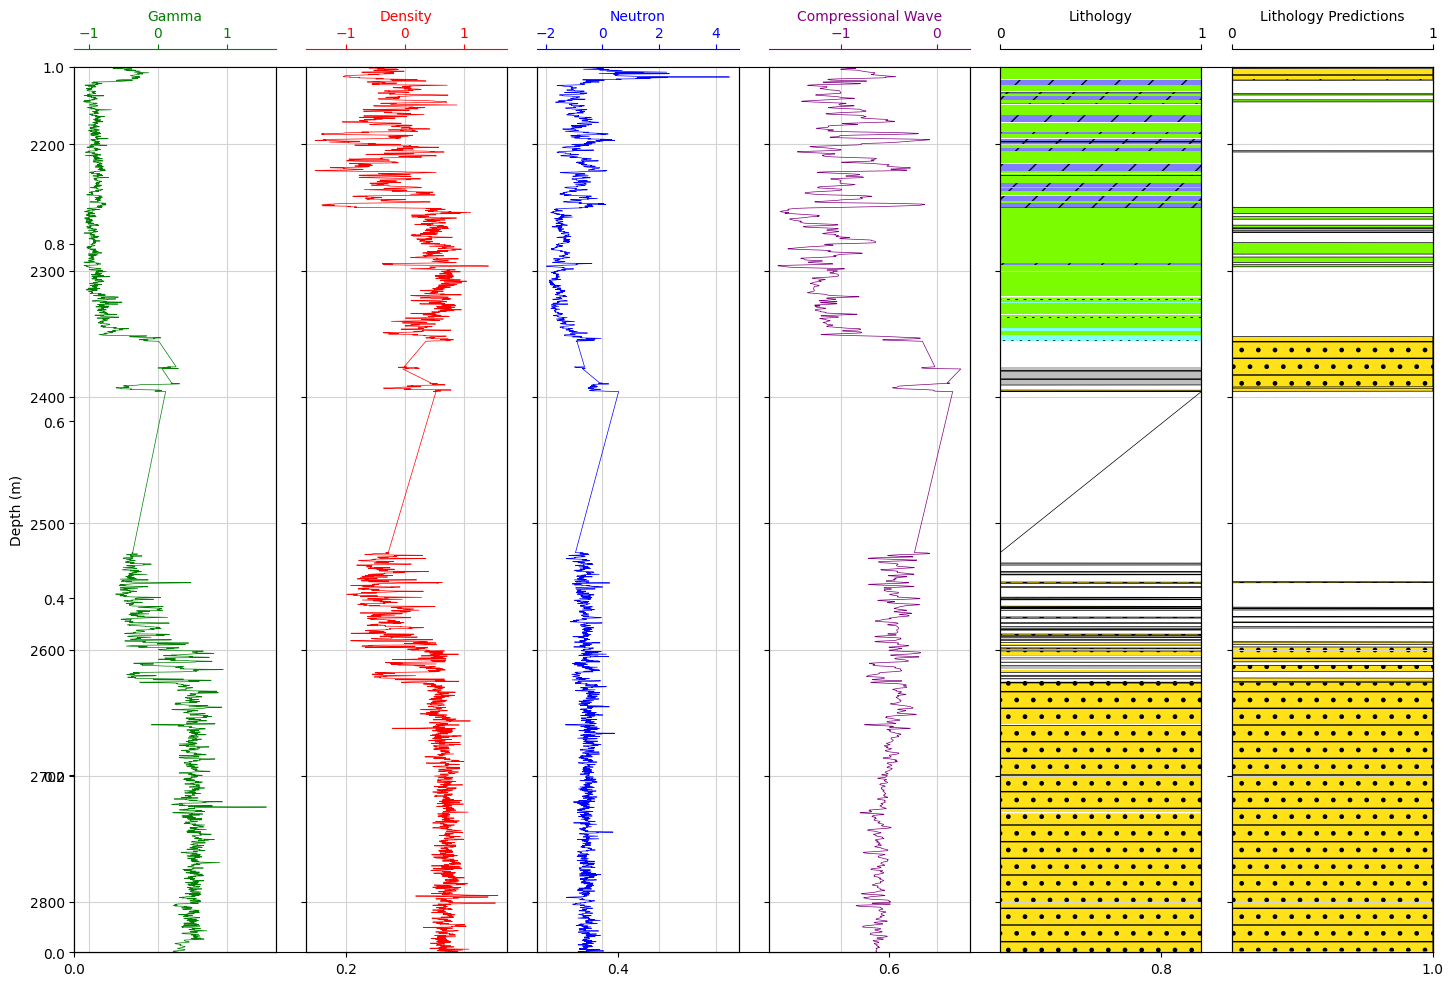

In [179]:
makeplot(plot_df, plot_df['DEPTH_MD'].min(), plot_df['DEPTH_MD'].max())